# Get and Format data 

In [1]:
from tqdm import tqdm
import gzip
import os
import shutil
import urllib.request
import requests
import json
import io
import pandas as pd
import numpy as np
import rampwf as rw
from rampwf.workflows.sklearn_pipeline import SKLearnPipeline, Estimator
from rampwf.prediction_types import make_regression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from problem import *

In [2]:
X_train, Y_train = get_train_data()
X_test, Y_test = get_test_data()

In [3]:
X_train.head()

,numero_dpe,usr_diagnostiqueur_id,usr_logiciel_id,tr001_modele_dpe_id,nom_methode_dpe,version_methode_dpe,nom_methode_etude_thermique,version_methode_etude_thermique,date_visite_diagnostiqueur,date_etablissement_dpe,...,tv017_zone_hiver_code,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_code,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
id,,,,,,,,,,,,,,,,,,,,,
11700150,2177C1000098S,20596,2,20,3CL - DPE,V2012,\N,\N,2021-06-30,2021-06-30,...,H1,6.58,10.5,42030,3.6,Eb,3,5,2.0,3
6444959,1883V8000291Y,18960,2,8,3CL - DPE,V2012,\N,\N,2018-06-20,2018-06-26,...,H3,9.65,14.5,22200,2.9,Ed,5,7,4.0,5
3931468,1627V3000032I,6211,13,3,FACTURE SEULE,V2012,\N,\N,2016-10-13,2016-10-13,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
475908,1375V4001133M,2360,3,4,Méthode Facture,None,\N,\N,2013-11-19,2013-11-28,...,H1,6.58,10.5,42030,3.6,Eb,3,5,2.0,3
7916375,1967V8000204V,12091,5,8,FACTURE,VERSION_2012,\N,\N,2019-05-07,2019-05-07,...,H1,6.58,10.5,42030,3.6,Eb,3,5,2.0,3


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197364 entries, 11700150 to 4133081
Columns: 126 entries, numero_dpe to tv018_zone_ete_rclim_dernier_etage
dtypes: float64(20), int64(26), object(80)
memory usage: 191.2+ MB


In [5]:
Y_train.head()

,classe_consommation_energie,classe_estimation_ges
id,,
11700150,G,C
6444959,G,D
3931468,D,C
475908,D,B
7916375,G,C


In [6]:
X_train.shape

(197364, 126)

In [7]:
X_test.shape

(84585, 126)

In [8]:
Y_train.shape

(197364, 2)

In [9]:
Y_test.shape

(84585, 2)

In [10]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

df = pd.concat([df_train, df_test], axis=0)

In [11]:
df_train.shape

(197364, 128)

In [12]:
df.describe()

,usr_diagnostiqueur_id,usr_logiciel_id,tr001_modele_dpe_id,tr002_type_batiment_id,annee_construction,tv016_departement_id,etat_avancement,est_efface,longitude,latitude,...,tv016_departement_fecs_ancienne_i_c,tv016_departement_fecs_recente_i_c,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
count,281949.000000,281949.000000,281949.000000,281949.000000,281949.000000,281949.000000,281949.0,281949.0,219015.000000,219015.000000,...,281949.000000,281949.000000,281949.00000,281949.000000,281949.000000,281949.000000,281949.000000,281949.000000,281949.000000,281949.000000
mean,10242.808934,5.558239,8.271985,4.029903,1628.157270,54.117269,1.0,0.0,2.702949,47.160261,...,30.101522,43.322796,7.32301,11.337056,37507.216305,3.471538,3.369099,5.369099,2.456038,3.369099
std,5655.339872,3.946389,5.005170,0.170319,744.929147,26.393202,0.0,0.0,2.770905,2.093917,...,4.952984,8.865802,1.02463,1.251469,6425.521812,0.211149,0.913246,0.913246,0.794904,0.913246
min,3.000000,2.000000,1.000000,4.000000,-1.000000,1.000000,1.0,0.0,-61.525777,16.415924,...,24.000000,0.000000,6.58000,10.500000,22200.000000,2.900000,2.000000,4.000000,1.500000,2.000000
25%,5902.000000,3.000000,4.000000,4.000000,1947.000000,33.000000,1.0,0.0,1.095212,45.716547,...,26.000000,38.000000,6.58000,10.500000,33300.000000,3.400000,3.000000,5.000000,2.000000,3.000000
50%,10136.000000,3.000000,8.000000,4.000000,1948.000000,59.000000,1.0,0.0,2.415274,47.685095,...,29.000000,42.000000,6.58000,10.500000,42030.000000,3.600000,3.000000,5.000000,2.000000,3.000000
75%,14270.000000,10.000000,8.000000,4.000000,1982.000000,75.000000,1.0,0.0,4.868344,48.857501,...,32.000000,47.000000,8.08000,12.000000,42030.000000,3.600000,4.000000,6.000000,3.000000,4.000000
max,25879.000000,16.000000,24.000000,5.000000,20011.000000,97.000000,1.0,0.0,9.551810,51.080627,...,43.000000,62.000000,9.65000,14.500000,42030.000000,3.600000,5.000000,7.000000,4.000000,5.000000


In [13]:
# useless columns
df_filtered = df.drop(
    columns=[
        "numero_dpe",
        "usr_diagnostiqueur_id",
        "usr_logiciel_id",
        "tr001_modele_dpe_id",
        "nom_methode_dpe",
        "version_methode_dpe",
        "nom_methode_etude_thermique",
        "version_methode_etude_thermique",
        "date_visite_diagnostiqueur",
        "date_etablissement_dpe",
        "date_arrete_tarifs_energies",
        "commentaires_ameliorations_recommandations",
        "explication_personnalisee",
        "commune",
        "arrondissement",
        "type_voie",
        "nom_rue",
        "numero_rue",
        "code_postal",
        "code_insee_commune",
        "code_insee_commune_actualise",
        "numero_lot",
        "nom_centre_commercial",
        "longitude",
        "latitude",
    ]
)
df_filtered.shape

(281949, 103)

In [14]:
# keep column with int type
df_filtered_float = df_filtered.select_dtypes(include=["int", "float"])
df_filtered_float.shape

(281949, 41)

In [17]:
# keep columns with less than 10% missing data
df_ = df_filtered_float.dropna(thresh=len(df_filtered) * 0.9, axis=1)
df_.shape

(281949, 36)

In [18]:
df_filtered.dtypes

tr002_type_batiment_id                  int64
secteur_activite                       object
tr012_categorie_erp_id                 object
tr013_type_erp_id                      object
annee_construction                      int64
                                       ...   
tv018_zone_ete_sclim_sup_150            int64
tv018_zone_ete_rclim_autres_etages    float64
tv018_zone_ete_rclim_dernier_etage      int64
classe_consommation_energie            object
classe_estimation_ges                  object
Length: 103, dtype: object

# Look at NaN

<Axes: ylabel='id'>

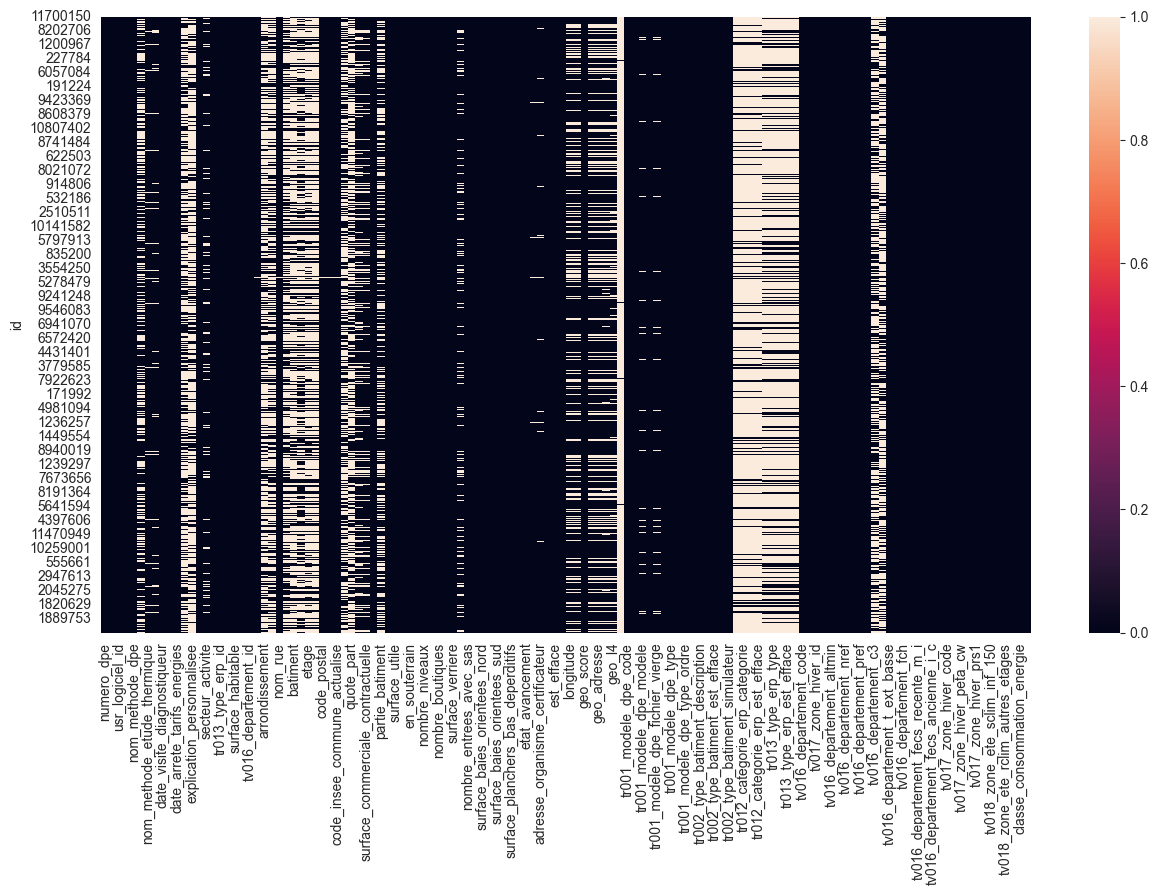

In [19]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isna())

# Plot interactive map

In [20]:
dpe = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326
)
dpe = dpe.dropna(subset=["longitude", "latitude"])

In [21]:
palette = sns.color_palette("coolwarm", 8)


def interactive_map_dpe(dpe):
    # convert in number
    dpe["color"] = [
        ord(dpe.iloc[i]["classe_consommation_energie"].lower()) - 96
        for i in range(len(dpe))
    ]
    dpe = dpe.loc[dpe["color"] <= 7]
    dpe["color"] = [palette.as_hex()[x] for x in dpe["color"]]

    center = dpe[["latitude", "longitude"]].mean().values.tolist()
    sw = dpe[["latitude", "longitude"]].min().values.tolist()
    ne = dpe[["latitude", "longitude"]].max().values.tolist()

    m = folium.Map(location=center, tiles="Stamen Toner")

    # I can add marker one by one on the map
    for i in range(0, len(dpe)):
        folium.Marker(
            [dpe.iloc[i]["latitude"], dpe.iloc[i]["longitude"]],
            popup=f"Année de construction: {dpe.iloc[i]['annee_construction']}, <br>DPE: {dpe.iloc[i]['classe_consommation_energie']}",
            icon=folium.Icon(
                color="black", icon="home", icon_color=dpe.iloc[i]["color"]
            ),
        ).add_to(m)

    m.fit_bounds([sw, ne])

    return m


m = interactive_map_dpe(dpe.head(10))

/Users/guillaumephilippe/own-ramp-kit/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
m

# Look at labels

In [23]:
Y_train.head()

,classe_consommation_energie,classe_estimation_ges
id,,
11700150,G,C
6444959,G,D
3931468,D,C
475908,D,B
7916375,G,C


In [24]:
Y_train.iloc[:, 0].value_counts()

D    48389
C    43723
E    31513
G    24555
B    17588
F    17477
A    14119
Name: classe_consommation_energie, dtype: int64

In [25]:
Y_train.iloc[:, 1].value_counts()

B    57984
C    51009
A    37270
D    30462
E    12941
F     4317
G     3381
Name: classe_estimation_ges, dtype: int64

In [26]:
Y_train.describe()

,classe_consommation_energie,classe_estimation_ges
count,197364,197364
unique,7,7
top,D,B
freq,48389,57984


In [27]:
Y = pd.concat([Y_train, Y_test], axis=0)
Y.shape

(281949, 2)

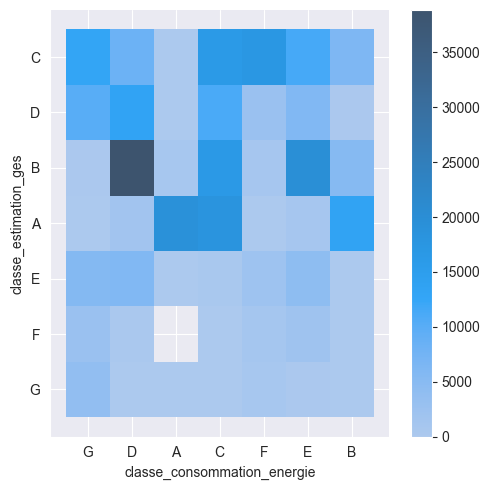

In [28]:
sns.displot(
    Y,
    x="classe_consommation_energie",
    y="classe_estimation_ges",
    row_order=["A", "B", "C", "D", "E", "F", "G", "H"],
    col_order=["A", "B", "C", "D", "E", "F", "G", "H"],
    cbar=True,
)
plt.show()